In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [6]:
# This loads the full dataset (~99 rows based on current sheet; adjust if more data is added)
df = pd.read_csv('https://docs.google.com/spreadsheets/d/14i7oWnBOoIf3pai37bsGYkby3VXJL1AlX_KxC8ZMKtg/export?format=csv')

In [7]:
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df['Date'] = df['Date Time Served'].dt.date
df['Item'] = df['Alcohol Type'] + ' - ' + df['Brand Name']

In [8]:
daily_consumption = df.groupby(['Bar Name', 'Item', 'Date'])['Consumed (ml)'].sum().reset_index()
daily_consumption['Date'] = pd.to_datetime(daily_consumption['Date'])

In [9]:
def forecast_and_par(ts, lead_time=3, safety_factor=1.65, forecast_steps=7):
    # Resample to daily, fill missing with 0
    ts = ts.set_index('Date')['Consumed (ml)'].resample('D').sum().fillna(0)
    
    # Fit ARIMA (simple order; may need tuning for better accuracy)
    model = ARIMA(ts, order=(1,1,1))
    fit = model.fit()
    forecast = fit.forecast(steps=forecast_steps)
    
    # Calculate metrics
    avg_daily_demand = forecast.mean()
    std_dev = forecast.std()
    safety_stock = safety_factor * std_dev * np.sqrt(lead_time)
    par_level = (avg_daily_demand * lead_time) + safety_stock
    
    return par_level, forecast

In [10]:
recommendations = []
unique_bar_items = daily_consumption.groupby(['Bar Name', 'Item'])
for (bar, item), group in unique_bar_items:
    par, forecast = forecast_and_par(group)
    recommendations.append({'Bar Name': bar, 'Item': item, 'Recommended Par Level (ml)': round(par, 2)})
rec_df = pd.DataFrame(recommendations)

In [11]:
print("Recommended Par Levels:")
print(rec_df)

Recommended Par Levels:
          Bar Name                Item  Recommended Par Level (ml)
0   Anderson's Bar    Beer - Budweiser                       11.06
1   Anderson's Bar        Beer - Coors                      191.72
2   Anderson's Bar     Beer - Heineken                      183.54
3   Anderson's Bar       Beer - Miller                      152.24
4   Anderson's Bar       Rum - Bacardi                      226.23
..             ...                 ...                         ...
91    Thomas's Bar   Whiskey - Jameson                      106.96
92    Thomas's Bar  Whiskey - Jim Beam                      220.22
93    Thomas's Bar     Wine - Barefoot                      194.59
94    Thomas's Bar  Wine - Sutter Home                       82.25
95    Thomas's Bar  Wine - Yellow Tail                      355.97

[96 rows x 3 columns]


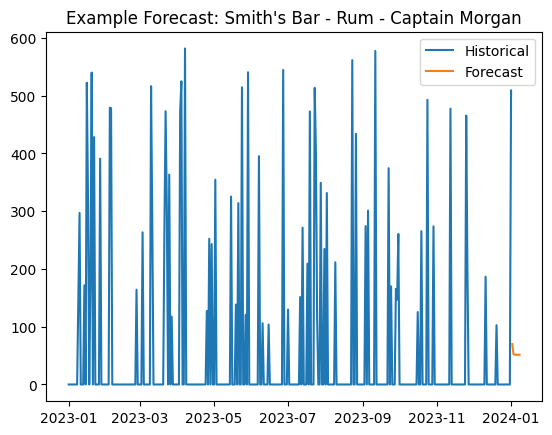

In [12]:
example_bar = "Smith's Bar"  # Note: Use exact name from data (apostrophe)
example_item = 'Rum - Captain Morgan'
example_group = daily_consumption[(daily_consumption['Bar Name'] == example_bar) & 
                                  (daily_consumption['Item'] == example_item)]
ts = example_group.set_index('Date')['Consumed (ml)'].resample('D').sum().fillna(0)
model = ARIMA(ts, order=(1,1,1))
fit = model.fit()
forecast = fit.forecast(steps=7)
plt.plot(ts, label='Historical')
plt.plot(forecast, label='Forecast')
plt.title(f'Example Forecast: {example_bar} - {example_item}')
plt.legend()
plt.show()

In [13]:
def simulate_inventory(ts, par_level, lead_time=3):
    inventory = par_level
    stockouts = 0
    for demand in ts:
        inventory -= demand
        if inventory < 0:
            stockouts += 1
            inventory = 0  # Assume emergency refill to 0
        # Reorder logic (simplified)
        if inventory < par_level / 2:
            inventory += par_level - inventory  # Reorder to par
    return stockouts / len(ts) * 100 if len(ts) > 0 else 0  # % stockout days

In [14]:
example_ts = ts.values
example_par = rec_df[(rec_df['Bar Name'] == example_bar) & 
                     (rec_df['Item'] == example_item)]['Recommended Par Level (ml)'].values[0]
stockout_rate = simulate_inventory(example_ts, example_par)
print(f"Simulated Stockout Rate for Example ({example_bar} - {example_item}): {stockout_rate:.2f}%")

Simulated Stockout Rate for Example (Smith's Bar - Rum - Captain Morgan): 14.21%


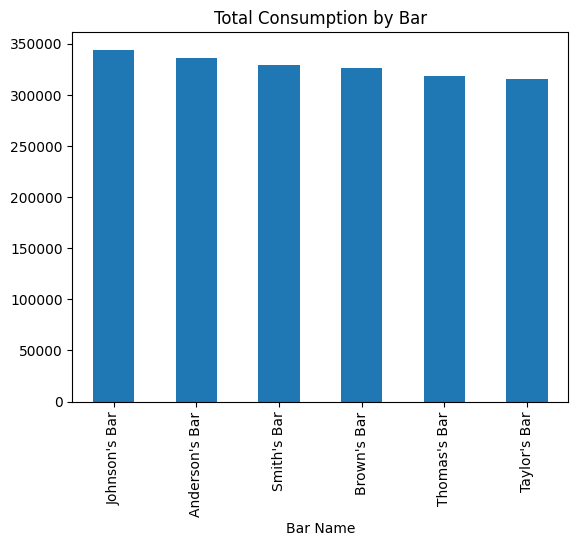

In [15]:
total_cons_by_bar = df.groupby('Bar Name')['Consumed (ml)'].sum().sort_values(ascending=False)
total_cons_by_bar.plot(kind='bar', title='Total Consumption by Bar')
plt.show()